代码说明：

1. 扩散过程：

前向扩散逐步添加噪声：x_t = √ᾱₜ x₀ + √(1-ᾱₜ)ε

使用线性噪声调度（beta从0.0001到0.02）

2. 去噪网络：

基于Transformer架构

输入含有时序嵌入的噪声文本

预测当前步的噪声ε

3. 改写生成：

控制strength参数决定改写程度（0-1）

反向扩散过程逐步去噪

最终通过嵌入矩阵映射回离散token

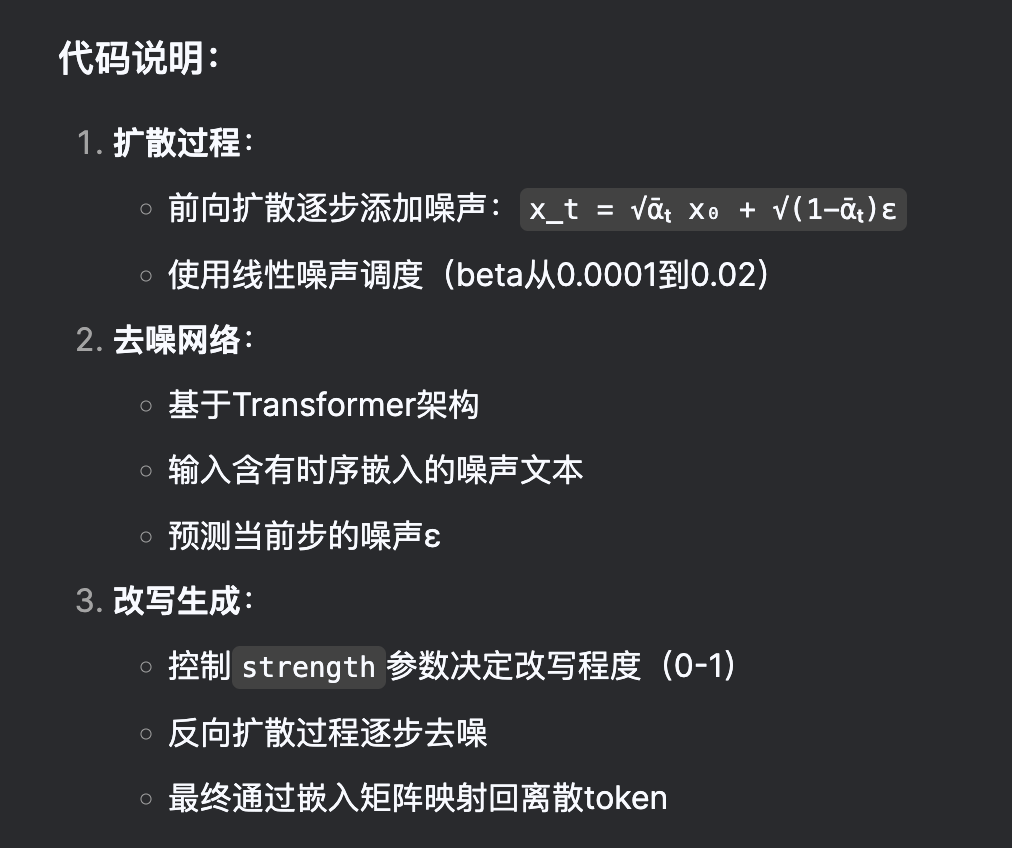

In [54]:
import torch
import torch.nn as nn
from torch.nn import Transformer

class TextDiffusion(nn.Module):
    def __init__(self, vocab_size=128, embed_dim=64, num_steps=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.transformer = Transformer(
            d_model=embed_dim,
            nhead=4,
            num_encoder_layers=3,
            num_decoder_layers=3
        )
        self.num_steps = num_steps
        
        # 定义噪声调度
        self.beta = torch.linspace(0.0001, 0.02, num_steps)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def forward_diffusion(self, x_0, t):
        """前向扩散过程"""
        batch_size, seq_len = x_0.shape[0], x_0.shape[1]
        epsilon = torch.randn_like(x_0.float())
        
        alpha_bar_t = self.alpha_bar[t].view(-1, 1, 1)
        x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * epsilon
        # print("========x_t==========")
        # print(x_t)
        # print("========epsilon==========")
        # print(epsilon)
        return x_t, epsilon

    def denoise_step(self, x_t, t):
        """去噪预测"""
        time_emb = self.time_embedding(t).unsqueeze(1)        
        x_emb = x_t 
        combined = x_emb + time_emb.squeeze().expand_as(x_emb)
        return self.transformer(combined, combined)

    def time_embedding(self, t, dim=64):
        """时间步位置编码"""
        inv_freq = 1 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        pos_enc_a = torch.sin(t * inv_freq)
        pos_enc_b = torch.cos(t * inv_freq)
        return torch.cat([pos_enc_a, pos_enc_b], dim=-1)

    def rewrite(self, text, strength=0.51):
        """文本改写生成"""
        with torch.no_grad():
            x = self.embedding(text)
            # print("====================embedding====================")
            # print(x)
            # 添加可控噪声
            t = int(strength * self.num_steps)
            # print(x.shape)
            x_t, _ = self.forward_diffusion(x, torch.tensor([t]))
            # print(x_t)
            # 去噪过程
            for t in reversed(range(t)):
                pred_noise = self.denoise_step(x_t, torch.tensor([t]))
                x_t = (x_t - self.beta[t]/torch.sqrt(1-self.alpha_bar[t]) * pred_noise) \
                      / torch.sqrt(self.alpha[t])
                # print(f"======{t}=======")
                # print(x_t)
            
            # 从嵌入映射回token
            logits = torch.matmul(x_t, self.embedding.weight.T)
            # print(logits)
            return torch.argmax(logits, dim=-1)

# 使用示例
if __name__ == "__main__":
    l1 = [4464,486,6352,5619,2465,4802,1452,3137,5778,5445,26,6663,5530,4149,2986,1746,5491,3659,2662,3002,2986,6182,4603,3220,1699,5689,5445,1920,1567,1460,1407,4403,3750,4893,648,3002,2986,2540,2329,7399,6122,3762,648,6182,4603,2400,669,1571,6713,3099,4659,3247,7543,648,656,495,3750,3618,4516,1567,5998,6811,6182,4603,1375,5948,1726,1289,340,5769,2556,3002,2986,2540,2329,3750,4811,2121,5472,6453,2540,2329,648,5839,4350,3000,900,7469,816,7399,4914,5310,299,3750,418,5542,1386,619,3686,1567,3750,2741,1567,6733,6405,3750,2515,4796,3634,5410,1289,2376,3750,314,2515,1726,5839,6122,3007,1726,6407,1769,900,2415,2986,5810,5810,5928,6734,3750,314,4796,5928,6734,2490,1726,6407,1769,1308,6810,4659,4516,6654,307,4480,3750,742,5977,656,4516,2515,4796,900,6770,6469,1647,6293,7539,6182,4603,450,4558,5977,656,4516,1726,6407,1769,3750,314,2515,2693,216,3750,3634,5410,1289,2376,3750,4655,656,495,7255,7010,3750,4190,1375,5948,4811,2121,6395,1726,2422,350,900,1057,2986,6182,4603,5998,6811,5482,45,6182,4603,1375,5948,7509,4124,3686,5769,2556,1158,6407,340,5105,6656,2112,900,6919,7399,4462,3686,3750,3634,53,7045,5482,6122,6050,4525,5977,544,3634,2402,3634,1736,5505,7010,192,6122,5677,900,742,5977,3634,5410,5560,3634,5977,5041,5482,45,6122,5677,3750,478,7239,5482,45,648,868,4480,669,3915,3765,2109,900,5482,45,3659,3370,4628,1924,4525,5977,1375,5948,23,7256,5787,656,2646,5482,45,648,5139,4758,5560,5938,5681,5482,45,1154,1592,648,5689,3945,900,6770,6469,1647,6293,7539,5482,45,5445,6928,5839,4265,6875,3750,1375,5948,62,307,7010,192,648,2522,4480,3750,4128,5393,1816,6182,4603,2304,4659,512,4124,648,2121,6929,900,1060,2986,6182,4603,5769,2556,1060,2986,2540,2329,1866,4124,648,5858,5949,1394,4939,7469,816,5695,900,7469,816,7399,289,5310,299,3750,314,2515,7543,5176,5659,1737,3166,7059,3750,5695,3686,900,314,1057,4969,4440,3750,314,2741,2741,5542,7123,3686,3750,5948,314,2515,340,2741,5542,1699,1641,6104,2490,5530,5510,5695,6734,3750,1277,4659,2109,4796,5659,4063,4796,6093,3700,3370,5106,5560,2109,4796,5659,1737,3166,307,5445,3750,5928,307,3481,1057,900,478,7239,4655,5998,1903,7010,192,5445,7147,2986,5153,6405,3750,4167,5397,3263,3634,3686,1567,900,6770,6469,1647,6293,7539,669,3915,3220,1699,669,4603,2842,5998,1903,7010,192,25,656,3257,6182,4603,3750,5998,6811,7010,192,1460,1816,2515,4985,6630,591,648,1375,5393,2112,512,4063,900]
    input_text = torch.tensor([lst])
    model = TextDiffusion(vocab_size=8000)
    rewritten = model.rewrite(input_text)
    print(rewritten)
    ## 看看不同的都是哪些。
    for idx, (i, j) in enumerate(zip(l1, rewritten[0])):
        if i != j:
            print(idx, i, j)

/opt/anaconda3/envs/ml12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


tensor([[4464,  486, 6352, 5619, 2465, 4802, 1452, 3137, 5778, 5445,   26, 6663,
         5530, 4149, 2986, 1746, 5491, 3659, 2662, 3002, 2986, 6182, 4603, 3220,
         1699, 5689, 5445, 1920, 1567, 1460, 1407, 4403, 3750, 4893,  648, 3002,
         2986, 2540, 2329, 7399, 6122, 3762,  648, 6182, 4603, 2400,  669, 1571,
         6713, 3099, 4659, 3247, 7543,  648, 6213,  495, 3750, 3618, 4516, 1567,
         5998, 6811, 6182, 4603, 1375, 5948, 1726, 1289,  340, 5769, 2556, 3002,
         2986, 2540, 2329, 3750, 4811, 2121, 5472, 6453, 2540, 2329,  648, 5839,
         4350, 3000,  900, 7469,  816, 7399, 4914, 5310,  299, 3750,  418, 5542,
         1386,  619, 3686, 1567, 3750, 5551, 1567, 6733, 6405, 3750, 2515, 4796,
         3634, 5410, 1289, 2376, 3750,  314, 2515, 1726, 5839, 6122, 3007, 1726,
         6407, 1769,  900, 2415, 2986, 5810, 5810, 5928, 6734, 3750,  314, 4796,
         5928, 6734, 2490, 1726, 6407, 1769, 1308, 6810, 4659, 4516, 6654,  307,
         4480, 3750,  742, 5

In [55]:
## 做一个板块，就是专门生成对抗样本的板块，然后跟训练数据拼接起来就好。
## 至于FGSM https://blog.csdn.net/qq_51399582/article/details/134699501 一样，找一个板块专门生成，然后拼接起来即可。

## 有机会做一下独立embedding、基座embedding然后每一个分支一个独有的投影层这种、共用embedding的对比。
## 我们做的时候，还是要有一些消融实验的思路的，比如说三种实验方案，我们就严格按照实验方案来做对比实验。
## 这样才好真正做好对比。

## 如果是生成对抗样本那种，我们就看三个模型的表现：原始的表现，光用对抗样本的表现，原始和对抗样本混用的表现。
## 假设对抗样本有用，那我们就做对比，看看不同混乱水平的对抗样本、掺入不同比例的对抗样本是否能够起效。

In [56]:
def get_intersection(itr1, itr2):
    return set(itr1).intersection(set(itr2))
def get_left_unique(itr1, itr2): ## right unique 便不写了罢。
    return set(itr1) - set(itr2)